# Computational Methods in Economics

## Using PyDyp: Neoclassical Growth Model (NGM)

In [1]:
# Author: Alex Schmitt (schmitt@ifo.de)

import datetime
print('Last update: ' + str(datetime.datetime.today()))

Last update: 2020-02-02 20:40:07.897889


### Preliminaries

#### Import Modules

In [4]:
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
%matplotlib inline  

# from pydyp import DPP1, DPP2, convert
import pydyp

In [5]:
# from importlib import reload

### This Lecture

- [Pydyp - A DP Tool Box](#pydyp)
- [Application: The Aiyagari Model](#aiyagari)
    - [Setup](#setup)
    - [Implementation](#impl)
    - [Solving for a stationary equilibrium](#sree)

----------------------------------------------------------------------------------------------------------------------
<a id ='pydyp'></a>

## Pydyp - A DP Tool Box

In the previous lecture, we saw how to implement the *value function iteration* algorithm numerically, and how to use it to solve a dynamic programming problem. 

Importantly, the key ideas of this algorithm - approximate the value function using standard function approximation tools, finding it iteratively, solving optimization problems along the grid - are independent from any specific problem.

In other words, a lot of the code that we saw last time is the same across different DP problems. This makes DP problems conducive for implementing them in Pythin using a *class*.

Let's think about which elements are problem-specific, and hence need to be provided as inputs when creating an instance of such a DP class:

- the dimensionality of the problem (i.e. the number of state and control variables);
- the functional form of the (RHS of the) Bellman equation and possibly of one or more constraints;
- parameter values (e.g., running the model for different values for the discount factor $\beta$);
- the number of grid points, and the interval that they cover;
- the names of the variables, and their steady state values.

I have written a module named **pydyp** which contains different implementations of a DP class. Relevant for us is the **DPP1** class, which is suitable for DP problems with *one state variable*, e.g. the simple NGM with capital as its only state.

In the following, we use the **DPP1** class to solve the same NGM as in the previous lecture.

### Preliminaries

Start by defining the parameters and auxiliary functions, as in the previous lecture. 

#### Parameters (global)

In [6]:
## utility
beta = 0.8   # discount factor
nu = 2       # risk-aversion coefficient for consumption
eta = 1      # elasticity parameter for labor supply
## production
alpha = 0.25
delta = 0.1
## derived
A = (1 - beta * (1 - delta))/(alpha*beta)   # normalization parameter for production function => steady state k = 1
B = (1 - alpha) * A * (A - delta)**(-nu)  # normalization parameter for utility function => steady state h = 1

params = {'beta': beta, 'nu': nu, 'eta': eta, 'alpha': alpha, 'delta': delta, 'A': A, 'B': B }

#### Auxiliary Functions

In [7]:
def f(k, h, pm):
    """
    Evaluates a Cobb-Douglas production function with coefficient alpha and shift parameter A, for two inputs k and h
    """
    return pm['A'] * k**pm['alpha'] * h**(1 - pm['alpha'])

def u(c, h, pm):
    """
    Evaluates an additive-separable utility function with consumption and labor as arguments
    """
    return c**(1 - pm['nu'])/(1 - pm['nu']) - pm['B'] * h**(1 + pm['eta'])/(1 + pm['eta'])

#### Provide Steady State

Here, rather than computing the steady state, we just provide its values:

In [8]:
xs = np.array([1, 1.3, 1])

#### Bellman Equation

Here, we use constrained optimization, hence we need not only a function implementing the RHS of the Bellman equation, but also a function implementing the resource constraint.

Moreover, note that the Python functions that we use for function approximation (e.g. **convert**) are also contained in the **pydyp** module.

In [9]:
def be_rhs(x, k, coef, k_min, k_max, pm):
    """
    RHS of the Bellman equation: Objective function
    """
    kp = x[:int(len(x)/3)]
    c = x[int(len(x)/3) : 2 * int(len(x)/3)]
    h = x[2 * int(len(x)/3) : ]

    return (- u(c, h, pm) - \
            pm['beta'] * np.polynomial.chebyshev.chebval(pydyp.convert(kp, k_min, k_max), coef) )

In [10]:
def resource_con(x, k, pm):
    """
    RHS of the Bellman equation: Resource Constraint
    """    
    kp = x[:int(len(x)/3)]
    c = x[int(len(x)/3) : 2 * int(len(x)/3)]
    h = x[2 * int(len(x)/3) : ]
    
    return f(k, h, pm) + (1 - pm['delta']) * k - kp - c

#### Value Function Iteration

Finally, we need to provide some information for the grid - number of grid points and end points, as well as an initial guess for the approximation coefficients (**coef0**) and the optimization problem (**x0**).

In [11]:
## define parameters and grid
m = 10
k_min = 0.7
k_max = 1.3

## initital guess for coefficients and maximization problem
coef0 = np.zeros(m)
coef0[1] = 1
x0 = xs

At this point, we have all the information required to create an instance of the **DPP1** class, which we name **NGM**.

In [12]:
## create instance
NGM = pydyp.DPP1(be_rhs, coef0, m, k_min, k_max, params, \
                 'k', ['c', 'h'], x0, [(k_min, k_max), (1e-8, 1e+8), (1e-8, 1e+8)], \
                 constraints = resource_con, ss = xs)   

We can check the inputs into this class by running

In [17]:
?pydyp.DPP1

Once we have this instance, we can run its **run_vfi** method. It essentially does two things:
- It runs the value function iteration algorithm introduced in the last lecture. The main result of this is an array of coefficients used to approximate the value function. It can be accessed in the instance's **coef** attribute. 
- If the optional argument **sim** is set to **True**, it runs a simulation, starting at the initial state given by **state_init** and for **T** periods. 

9.901950556835228e-09 95


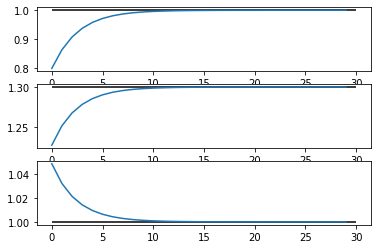

In [14]:
## run VFI
NGM.run_vfi(sim = True, state_init = 0.8, T = 30)

print(NGM.err, NGM.it)

In [15]:
NGM.coef

array([[-5.41322415e+00],
       [ 2.28510731e-01],
       [-1.39611104e-02],
       [ 1.31321781e-03],
       [-1.47532586e-04],
       [ 1.80942583e-05],
       [-2.33420385e-06],
       [ 3.11277341e-07],
       [-4.26169139e-08],
       [ 5.78920407e-09]])

Note that the result of the simulation, the time paths for the model variables, is stored as a Pandas time series, which is stored in the instance's **ts** attribute. 

In [16]:
NGM.ts.head()

,k,c,h
0,0.800000,1.227494,1.048325
1,0.864248,1.251696,1.031903
2,0.908155,1.267711,1.021196
3,0.937981,1.278368,1.014142
4,0.958172,1.285486,1.009462


----------------------------------------------------------------------------------------------------------------------
<a id ='aiyagari'></a>

## Application: The Aiyagari Model

### The Aiyagari Model: Introduction

The NGM considered above is an example of a *representative-agent* economy. 

While these types of models are prevalent in economic analysis, they are not suitable for applications that feature *heterogeneity* across agents and/or are interested in questions concerning the *distribution* of income, wealth, welfare etc.

As an example, consider a paper by Domeij and Heathcote (2004) "On the distributional effects of reducing capital taxes" (in the course repository). 

It addresses the question whether household heterogeneity - specifically, the presence of "idiosyncratic" (household-specific) uninsurable income risk - have quantitatively important implications for the welfare effects of tax changes, i.e. reducing capital income taxes while increasing labor income taxes.

To answer this question, the paper uses the *Aiyagari model*, the workhorse model for analyzing heterogeneous households under market incompleteness (and without *aggregate* uncertainty, e.g. productivity shocks). 

For more background, compare the survey paper by Krusell and Smith (2006), section 3.1 (in the course repository).

------------------------------------------------------------------------------------------------------------------------------
<a id = 'setup'></a>

### The Aiyagari Model: Setup

The following exposition is taken from QuantEcon's lecture on the Aiyagari model: https://lectures.quantecon.org/py/aiyagari.html

#### Households

Infinitely lived households / consumers face *idiosyncratic* (i.e., household-specific) income shocks.

A unit interval of  *ex-ante* identical households face a common borrowing constraint.

The savings problem faced by a typical  household is

$$
\max \mathbb E \sum_{t=0}^{\infty} \beta^t u(c_t)
$$

subject to

$$
a_{t+1} + c_t \leq w z_t + (1 + r) a_t
\quad
c_t \geq 0,
\quad \text{and} \quad
a_t \geq \underline{a}
$$


where

- $ c_t $ is current consumption  
- $ a_t $ is assets  
- $ z_t $ is an exogenous component of labor income capturing stochastic unemployment risk, etc.  
- $ w $ is a wage rate  
- $ r $ is a net interest rate  
- $ \underline{a} $ is the maximum amount that the agent is allowed to borrow  

The wage and interest rate are fixed over time. Thus, we focus on a *steady state* setting.

In this simple version of the model, households supply labor inelastically because they do not value leisure.

The exogenous process $ \{z_t\} $ follows a finite-state Markov chain with given *probability transition matrix* $ P $. 

In other words, $z_t$ is a discrete random variable whose "support" consists of a finite number of values. 

For example, consider the case where the support of $z$ consists of two values (a low state and a high state). Then, $P$ would be given by

\begin{equation}
    P =  \left[\begin{array}{cc}
    p_{00} & p_{01} \\
    p_{10} & p_{11} \\
    \end{array}\right]
\end{equation}

The element $p_{ij}$ denotes the constant probability to move from state $i$ to state $j$ between two periods. Hence, it has to hold that $p_{00} + p_{01} = 1$ and $p_{10} + p_{11} = 1$.

Before discussing dynamic programming, think about solving this model using a sequential approach. 

Why is this much more computationally intensive than for the deterministic model we have seen before? In other words, how many variables would the algorithm have to find when solving the model for a finite number of periods $T$?

#### Firms

Firms produce output by hiring capital and labor.

Firms act competitively and face constant returns to scale.

Since returns to scale are constant the number of firms does not matter.

Hence we can consider a single (but nonetheless competitive) representative firm.

The firm’s output is

$$
Y_t = K_t^{\alpha} N^{1 - \alpha}
$$

where

- $ \alpha $ is a parameter, $ \alpha \in (0, 1) $  
- $ K_t $ is aggregate capital  
- $ N $ is total labor supply (which is constant in this simple version of the model)  

The firm’s problem is

$$
max_{K, N} \left\{ K_t^{\alpha} N^{1 - \alpha} - (r + \delta) K - w N \right\}
$$

The parameter $ \delta $ is the depreciation rate.

From the first-order condition with respect to capital, the firm’s inverse demand for capital is


<a id='equation-aiy-rgk'></a>
$$
r = \alpha  \left( \frac{N}{K} \right)^{1 - \alpha} - \delta \tag{1}
$$

Using this expression and the firm’s first-order condition for labor, we can pin down
the equilibrium wage rate as a function of $ r $ as


<a id='equation-aiy-wgr'></a>
$$
w(r) = (1 - \alpha)  (\alpha / (r + \delta))^{\alpha / (1 - \alpha)} \tag{2}
$$

It will be useful to implement these two expressions in a function:

In [30]:
def get_prices(K, params):
    Y = f(K, params['n'], params)
    R = params['alpha'] * Y / K - params['delta']
    W = (1 - params['alpha']) * Y / params['n']
    return R, W

#### Equilibrium

We construct  a *stationary rational expectations equilibrium* (SREE).

In such an equilibrium

- prices induce behavior that generates aggregate quantities consistent with the prices  
- aggregate quantities and prices are *constant* over time  

In more detail, an SREE lists a set of prices, savings and production policies such that

- households want to choose the specified savings policies taking the prices as given  
- firms maximize profits taking the same prices as given  
- the resulting aggregate quantities are consistent with the prices; in particular, the demand for capital equals the supply  
- aggregate quantities (defined as cross-sectional averages) are constant  

In practice, once parameter values are set, we can check for an SREE by the following steps

1. pick a proposed quantity $ K $ for aggregate capital  
1. determine corresponding prices, with interest rate $ r $ determined by [(1)](#equation-aiy-rgk) and a wage rate $ w(r) $ as given in [(2)](#equation-aiy-wgr)  
1. determine the common optimal savings policy of the households given these prices  
1. compute aggregate capital as the mean of steady state capital given this savings policy  


If this final quantity agrees with $ K $ then we have a SREE.

--------------------------------------------------------------------------------------------------------------------------------
<a id = "impl"></a>

### The Aiyagari Model: Implementation

In the following, we will replicate some of the results in Domeij and Heathcote and (D&H, 2004). Note that since this is a paper about tax reform, the household's budget constraint is subject to a tax on labor income $\tau_n$ and on capital income $\tau_k$. In other words, there are two additional model parameters.

Moreover, the paper assumes that the borrowing limit is 0, i.e. $\underline{a} = 0$.

Hence, the household problem now reads:

$$
\max \mathbb E \sum_{t=0}^{\infty} \beta^t u(c_t)
$$

subject to

$$
a_{t+1} + c_t \leq (1 - \tau_h) W \bar{n} z_t + [1 + (1 - \tau_k) R]  a_t
\quad
c_t \geq 0,
\quad \text{and} \quad
a_t \geq 0
$$


Another modification of this model compared to version above is the presence of government debt ("bonds"), denoted by $B$. That is, there two assets in the economy, physical capital $K$ and debt $B$. 

In equilibrium, the real one-period return to debt (which is guaranteed by the government and hence risk-free), in equilibrium the two assets must pay the same real return. Hence, it is not necessary to specify the division between capital and bonds in an individual’s portfolio.

Formally, the demand for asset holding - the sum (or actually integral, since there is a mass of households) of individual households' savings choice - must equal the sum of $K$ and $B$, the steady-stae supply of asset:

$$
    \sum_{i = 0}^N a^i_{t} = K + B\quad\ \forall t
$$

#### Parameters

In [18]:
## utility
beta = 0.965   # discount factor
## production
alpha = 0.36
delta = 0.06
## tax rates: taken from D&H, table 3
τ_n, τ_k = 0.269, 0.397

params = {'beta': beta, 'alpha': alpha, 'delta': delta, 'τ_n': 0.269, 'τ_k': 0.397, 'n': 0.3275 }

With regard to the stochastic process, the values for $z$ and its transition matrix are taken from D&H, p. 530 ff. They are chosen such that on average, the model reproduces certain features of the wealth distribution observed in the United States.

In [19]:
## stochastic states and transition matrix
z = np.array([0.167 , 0.839, 5.087])
Pi_11 = 0.9
Pi_22 = 0.99
Pi_33 = 0.9

P = np.array([[Pi_11, 1 - Pi_11, 0],
              [0.5*(1-Pi_22), Pi_22, 0.5*(1-Pi_22)],
              [0, 1 - Pi_33, Pi_33]])

#### Auxiliary Functions

In [20]:
def f(k, h, pm):
    """
    Production function
    """
    return k**pm['alpha'] * h**(1 - pm['alpha'])

def u(c, h, pm):
    """
    Utility function
    """
    return np.log(c)
#     return c**(1 - nu)/(1 - nu) - eta * h**(1 + psi)/(1 + psi)

#### Household Problem: Bellman Equation

In [21]:
def be_rhs(x, state, coef, a_min, a_max, pm, z, P):
    """
    RHS of the Bellman equation: Objective function
    """
    ap = x[:int(len(x)/2)]
    c = x[int(len(x)/2) : ]
    
    a, z_ind = state
    
    return (- u(c, 1, pm) - \
            pm['beta'] * P[z_ind, :] @ np.polynomial.chebyshev.chebval(pydyp.convert(ap, a_min, a_max), coef) )

In [22]:
def resource_con(x, state, pm, z):
    """
    RHS of the Bellman equation: Resource Constraint
    """    
    ap = x[:int(len(x)/2)]
    c = x[int(len(x)/2) : ]

    a, z_ind = state
    
    return (1 + (1 - pm['τ_k']) * pm['R']) * a + (1 - pm['τ_n']) * pm['W'] * pm['n'] * z[z_ind] - ap - c

#### Illustration: solve household problem

Here, we compute the solution to the household problem given above, for given prices $R$ and $W$, using the dynamic programming algorithm implemented in our **DPP1** class. In the context of the approach outlined above to find the equilibrium, this would correspond to step (3).  

In [69]:
## define parameters and grid
m = 10
a_min = 1e-6
a_max = 45

## initital guess for coefficients and maximization problem
coef0 = np.zeros(m)
coef0[1] = 1
coef0 = np.repeat(coef0, 3)
coef0.shape = (m, 3)

x0 = (2, 1)

We also need values for the wage and interest rate:

In [70]:
params['W'] = 1.265
params['R'] = 0.0472

In [71]:
## define problem
NGM1 = pydyp.DPP1(be_rhs, coef0, m, a_min, a_max, params, 'a', ['c'], x0, [(a_min, a_max), (1e-8, 1e+8)], \
            constraints = resource_con, z = z, P = P) 

In [72]:
## run VFI
# NGM1.run_vfi(sim = True, state_init = 1, T = 1000)
NGM1.run_vfi()
print(NGM1.err, NGM1.it)

100 0.5312686152758247
200 0.01791712998133894
300 0.0005277054312524755
400 1.504953344064397e-05
500 4.271750295284638e-07
600 1.2116749591299468e-08
9.78303686611078e-09 605


-------------------------------------------------------------------------------------------------------------------------------
<a id = sree></a>

### Solving for a stationary equilibrium 

In order to solve for the stationary equilibrium (the steady state), we follow the approach outlined above. To be more precise, these are the steps (from D&H): 

(a) Guess a value for the capital stock (and implicitly for output and prices)

(b) Compute the value for government debt such that given capital stock, the debt-to-GDP ratio is constant; from this, we also get the "implied" aggregate asset holdings (aggregate capital plus aggregate debt)

(c) Solve for household savings decisions (as above)

(d) Simulate the economy to generate a stationary asset-holding distribution

(e) Check that aggregate household savings equal aggregate asset holdings computed in (b)

(f) Adjust the guess for capital and iterate until the market for savings clears

Step (b) is implemented in the following function:

In [73]:
def get_implied_asset(K, params, share = 0.67):
    Y = f(K, params['n'], params) 
    B = share * Y
    
    return K + B, B   

In [ ]:
## prepare the loop
dist, eps = 1, 1e-5
it, maxit = 0, 20
phi = 0.9

## for simulation
N = 100000

## step (a)
K = 2.1544567780362396

Iteration 1: K = 2.1544567780362396
100 0.00040225657859301663
200 3.430077324111613e-06
300 8.395965952857099e-08
-7.011018268165969e-06


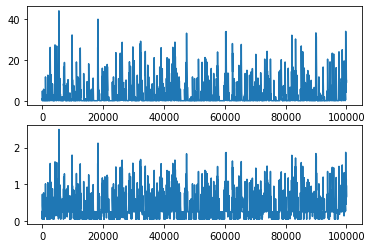

In [83]:
while abs(dist) > eps and it < maxit:
    it += 1
    print('Iteration {}: K = {}'.format(it, K))
    ## steps (a) and (b)
    R, W = get_prices(K, params)
    A_implied, B_implied = get_implied_asset(K, params)
    NGM1.pm['R'] = R
    NGM1.pm['W'] = W
    
    ## step (c) and (d)
    NGM1.run_vfi(sim = True, state_init = 1, T = N)
    
    ## step (e)
    A = NGM1.ts['a'].mean()
    dist = A - A_implied
    print(dist)
    ## step (f)
    K = phi * K + (1 - phi)*(A - B_implied)

#### Report results

Here, we compute some equilibrium results and compare them to tables 2 and 3 in D&H (column "Benchmark).

In [94]:
## compute output
Y = f(K, params['n'], params)
print(Y)
print(Y / K)

0.6452630354180183
0.2995015968653056


In [98]:
R, W = get_prices(K, params)
A, B = get_implied_asset(K, params)
## R (% post-tax)
print( (1 - params['τ_k']) * R * 100 )

2.883580664752053
0.2470915248293284


In [99]:
## post-tax asset to labor income ratio
print( (1 - params['τ_k']) * (K + B) * R / ( (1 - params['τ_n']) * W * params['n']) )

0.2470915248293284


In order to compute Gini coefficients, we use the following function:

In [ ]:
def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq: http://www.statsdirect.com/help/content/image/stat0206_wmf.gif
    # from: http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    array = array.flatten() #all values are treated equally, arrays must be 1d
    if np.amin(array) < 0:
        array -= np.amin(array) #values cannot be negative
    array += 0.0000001 #values cannot be 0
    array = np.sort(array) #values must be sorted
    index = np.arange(1,array.shape[0]+1) #index per array element
    n = array.shape[0]#number of array elements
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array))) #Gini coefficient

In [93]:
## Gini coefficient of asset holdings (cp. table 2, column 1)
dis = NGM1.ts['a'].sort_values()
print( gini(dis.values) )

0.77726566663846


In [88]:
## asset holding distribution: 99%-100%
dis.iloc[int(0.99 * N):].sum() / dis.sum()

0.10752021551286833

In [89]:
## asset holding distribution: 90%-100%
dis.iloc[int(0.9 * N):].sum() / dis.sum()

0.5816437241844808

In [90]:
## asset holding distribution: 80%-100%
dis.iloc[int(0.8 * N):].sum() / dis.sum()

0.81877911276473

In [91]:
## asset holding distribution: 0%-40%
dis.iloc[:int(0.4 * N)].sum() / dis.sum()

0.0010871207714458241

Note that we are not able to replicate the precise values reported by D&H, but our results are sufficiently close.